<a href="https://colab.research.google.com/github/glw/Fastai_DL_v1/blob/master/Google_Colab_fastai_v1_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and verify Pytorch 1.0 and FastAI 1.0 on Google Colab as of Oct. 22, 2018

In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 575.6MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x612c0000 @  0x7f0d039332a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 102kB 6.0MB/s 
    100% |████████████████████████████████| 61kB 20.9MB/s 
    100% |████████████████████████████████| 13.9MB 2.9MB/s 
    100% |████████████████████████████████| 112kB 29.9MB/s 
    100% |████████████████████████████████| 112kB 33.2MB/s 
    100% |████████████████████████████████| 2.2MB 1.4MB/s 
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
torchvision-nightly 0.2.1 has 

In [0]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.0.0.dev20181021
True
True


In [0]:
!pip list

In [0]:
import fastai
print(fastai.__version__)

from fastai import *
from fastai.vision import *

1.0.11


## Let's try out FastAI by classifying images of dogs and cats

In [0]:
path = untar_data(URLs.DOGS)
path

PosixPath('/root/.fastai/data/dogscats')

In [0]:
help(data)

Help on module fastai.vision.data in fastai.vision:

NAME
    fastai.vision.data - `vision.data` manages data input pipeline - folderstransformbatch input. Includes support for classification, segmentation and bounding boxes

CLASSES
    fastai.basic_data.DataBunch(builtins.object)
        ImageDataBunch
    fastai.basic_data.DatasetBase(torch.utils.data.dataset.Dataset)
        SegmentationDataset
    fastai.basic_data.LabelDataset(fastai.basic_data.DatasetBase)
        ImageDataset
            ImageClassificationDataset
        ImageMultiDataset
    torch.utils.data.dataset.Dataset(builtins.object)
        DatasetTfm
        ObjectDetectDataset
    
    class DatasetTfm(torch.utils.data.dataset.Dataset)
     |  `Dataset` that applies a list of transforms to every item drawn.
     |  
     |  Method resolution order:
     |      DatasetTfm
     |      torch.utils.data.dataset.Dataset
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __getattr__(self, 

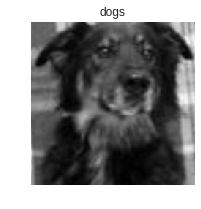

In [0]:
data = ImageDataBunch.from_folder(
    path, 
    ds_tfms=get_transforms(), 
    tfms=imagenet_norm, 
    size=224,
    num_workers=0
)
img,label = data.valid_ds[-1]
img.show(title=data.classes[label])

Only set *num_workers=0* because of PyTorch 1.0 Preview issue with Colab. Hopefully can remove in the future to speed up training through parallelization.

In [0]:
%%time
learn = ConvLearner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(1)

epoch  train loss  valid loss  accuracy


RuntimeError: ignored

In [0]:
%%timeit
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-5,3e-4), pct_start=0.05)

epoch  train loss  valid loss  accuracy
1      0.025223    0.018957    0.991000


Let's do test time augmentation.

In [0]:
%%timeit
accuracy(*learn.TTA())

tensor(0.9930)

You should see an accuracy score over .99.5%.

In [0]:
# memory footprint support libraries/code
# should be 11000+MB if you get the full RAM availability
# from https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi


Check general RAM and GPU RAM

In [0]:
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]

def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 13.0 GB  | Proc size: 138.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## MNIST hadwriting digit classification example that uses less memory

In [0]:
# path = untar_data(URLs.MNIST_SAMPLE)
# path

In [0]:
# data = ImageDataBunch.from_folder(path)


In [0]:
# learner = ConvLearner(data, models.resnet18, metrics=accuracy)

In [0]:
# learner.fit(2)

In [0]:
# learner .fit_one_cycle(1)

### Stop all sessions and release memory

In [0]:
# !kill -9 -1

In [0]:
Check out some specs

In [0]:
df -h

NameError: ignored

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) 

In [0]:

!cat /proc/meminfo

MemTotal:       13335204 kB
MemFree:        11346792 kB
MemAvailable:   12664968 kB
Buffers:           49124 kB
Cached:          1440296 kB
SwapCached:            0 kB
Active:           464772 kB
Inactive:        1297944 kB
Active(anon):     247680 kB
Inactive(anon):      328 kB
Active(file):     217092 kB
Inactive(file):  1297616 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               416 kB
Writeback:             0 kB
AnonPages:        271464 kB
Mapped:           156144 kB
Shmem:               844 kB
Slab:             120012 kB
SReclaimable:      90432 kB
SUnreclaim:        29580 kB
KernelStack:        3468 kB
PageTables:         4424 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667600 kB
Committed_AS:    1694392 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  